# Проект: промышленность

**Название проекта:**
<br>Оптимизация производственных расходов металлургического комбината «Стальная птица».</br>
_____
**Описание исследования**
<br>В рамках данного проекта необходимо проанализировать данные, связанные с процессом обработки стали, и разработать модель, способную прогнозировать температуру сплава. Это позволит предприятию улучшить контроль за технологическим процессом и снизить энергозатраты.</br>
_____
**Цель исследования**
<br>Создать предиктивную модель для прогнозирования температуры стали.</br>

*Суть исследования:*
Изучить данные, связанные с процессом обработки стали, провести их предварительную обработку и анализ, а затем построить модель, которая будет предсказывать температуру сплава для имитации технологического процесса.
_____
**Задачи исследования**
1. Изучить данные и оценить их качество.
2. Провести предобработку данных, включая ликвидацию пропусков и исправление ошибок.
3. Исследовать взаимосвязи между переменными, влияющими на температуру сплава.
4. Разработать и обучить модели для прогнозирования температуры.
5. Проверить лучшую модель на тестовых данных и оценить её точность.
6. Проести анализ важности признаков лучшей модели.
_____
**Исходные данные**
<br>Исследование базируется на нескольких наборах данных:</br>

- data_arc_new.csv: данные об электродах (начало, конец, мощность),
- data_bulk_new.csv: объёмы подаваемых сыпучих материалов,
- data_bulk_time_new.csv: время подачи сыпучих материалов,
- data_gas_new.csv: данные о продувке сплава газом,
- data_temp_new.csv: результаты измерений температуры,
- data_wire_new.csv: объёмы проволочных материалов,
- data_wire_time_new.csv: время подачи проволочных материалов.

<br>Все файлы содержат идентификатор партии/ковша `key`, который связывает данные между собой.</br>
_____


**Данное исследование разделим на несколько частей:**

[***Часть 1. Загрузка данных:***](#1-bullet)
<br>Загрузка необходимых библиотек и исходных файлов.</br>

[***Часть 2. Обзор данных:***](#2-bullet)
<br>Первичный осмотр данных, проверка типов данных, размеров таблиц, наличие пропусков и дубликатов.</br>
   
[***Часть 3. Исследовательский анализ и предобработка данных:***](#3-bullet)
- Изучить каждую таблицу: проверить распределения, найти аномалии.
- Привести данные к единому формату и при необходимости выполнить предобработку.
- Сгенерировать новые признаки при необходимости, выбрать признаки для построения модели. 

[***Часть 4. Объединение данных:***](#4-bullet)
<br>С помощью столбца key объединить таблицы в единый датафрейм, включающий только полезные признаки.</br>

[***Часть 5. Исследовательский анализ объединённого датафрейма:***](#5-bullet)
<br>Провести анализ объединённого датафрейма с визуализацией распределения.</br>

[***Часть 6. Корреляционный анализ:***](#6-bullet)
<br>Выявить корреляции между признаками.</br>

[***Часть 7. Построение моделей:***](#7-bullet)
1. Разделение данных на тренировочную и тестовую выборки.
2. Выполнить масштабирование и кодирование признаков при необходимости.
3. Обучить минимум две модели регрессии и настроить гиперпараметры хотя бы для одной модели.
5. Выбор лучшей модели на тренировочных данных.
6. Оценка качества модели на тестовых данных.
7. Анализ важностии факторов для лучшей модели и анализ остатков.

[***Часть 8. Общий вывод:***](#8-bullet)
- Описать основные этапы работы и полученные результаты.
- Дать рекомендации по использованию модели.

## Загрузка данных 

In [1]:
# Обновление библиотеки scikit-learn
!pip install scikit-learn --upgrade -q

# Установка дополнительных библиотек
!pip install catboost -q
!pip install lightgbm -q
!pip install phik -q
!pip install shap -q

# Импорт стандартных библиотек
import re
import time
import warnings
# Настройки предупреждений
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Импорт сторонних библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from catboost import CatBoostRegressor
from functools import reduce
from lightgbm import LGBMRegressor
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import norm, t
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Настройки Seaborn
sns.set_context(
    'notebook',
    rc={
        'font.size': 12,
        'font.weight': 'bold',
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'legend.title_fontsize': 10,
        'legend.titleweight': 'bold',
    }
)

In [2]:
# Определим время начала выполнения кода
start_time = time.time()

In [3]:
# Создание константы RANDOM_STATE
RANDOM_STATE = 91224

In [4]:
# Функция для преобразования строки в формат snake_case
def to_snake_case(column_name):
    """
    Преобразует строку в snake_case.
    Работает для строк на русском и английском языках.
    """
    # Добавляем нижнее подчёркивание перед каждой заглавной буквой (англ./рус.)
    column_name = re.sub(r'(?<!^)(?=[A-ZА-Я])', '_', column_name)
    # Заменяем пробелы на нижнее подчёркивание
    column_name = column_name.replace(' ', '_')
    # Приводим к нижнему регистру
    return column_name.lower()

In [5]:
# Универсальная функция для загрузки данных
def load_and_process_data(file_path, exclude_column='key'):
    """
    Загружает данные из CSV, автоматически определяет столбцы для преобразования в даты
    и переименовывает столбцы в snake_case.
    
    :param file_path: Путь к файлу CSV.
    :param exclude_column: Название столбца, который не нужно преобразовывать в дату (по умолчанию 'key').
    :return: DataFrame с обработанными данными.
    """
    # Загружаем данные без преобразования
    df = pd.read_csv(file_path)
    
    # Определяем столбцы, которые могут быть датами (все, кроме исключаемого)
    for col in df.columns:
        if col != exclude_column:  # Исключаем столбец 'key'
            # Проверяем, является ли столбец строковым (так как строки могут содержать даты)
            if df[col].dtype == 'object':
                # Пробуем преобразовать столбец в datetime с параметром errors='coerce' для обработки ошибок
                sample_data = pd.to_datetime(df[col], errors='coerce')
                
                # Проверяем, если хотя бы одно значение в столбце является датой (не NaT)
                if sample_data.notna().any():
                    # Преобразуем весь столбец в datetime, оставляя другие значения как NaT, если они некорректны
                    df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Переименование столбцов в snake_case
    df = df.rename(columns=to_snake_case)
    
    return df

In [6]:
# Функция для загрузки данных с обработкой ошибок
def safe_load_data(file_path):
    try:
        # Пытаемся загрузить данные с использованием функции load_and_process_data
        return load_and_process_data(file_path)
    except Exception as e:
        # В случае ошибки выводим сообщение и возвращаем None
        print(f"Ошибка при загрузке файла {file_path}: {e}")
        return None

In [7]:
# Прочитаем csv-файлы и сохраним в датафреймы с обработкой ошибок
df_arc = safe_load_data('/datasets/data_arc_new.csv')
df_bulk = safe_load_data('/datasets/data_bulk_new.csv')
df_bulk_time = safe_load_data('/datasets/data_bulk_time_new.csv')
df_gas = safe_load_data('/datasets/data_gas_new.csv')
df_temp = safe_load_data('/datasets/data_temp_new.csv')
df_wire = safe_load_data('/datasets/data_wire_new.csv')
df_wire_time = safe_load_data('/datasets/data_wire_time_new.csv')

In [8]:
# Собираем датафреймы в список с именами
dfs = [
    ('df_temp', df_temp),
    ('df_arc', df_arc),
    ('df_gas', df_gas),
    ('df_bulk', df_bulk),
    ('df_bulk_time', df_bulk_time),
    ('df_wire', df_wire),
    ('df_wire_time', df_wire_time)
]

<a id="2-bullet"></a>

##   Обзор данных

### Результаты измерений температуры

In [9]:
df_temp.head()

,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [10]:
df_temp['время_замера'].min()

Timestamp('2019-05-03 11:02:04')

In [11]:
df_temp['время_замера'].max()

Timestamp('2019-09-06 17:30:05')

Следует отметать, что один ковш в таблице встречается несколько раз в разное время. Это обуславливается взятием нескольких проб из одного ковша в процессе получения необходимого химического состава. 

В исходных данных присутствует информация в период с 3 мая по 6 сентября 2019 года включительно.

In [12]:
# Поиска явных дубликатов
df_temp.duplicated().sum()

0

In [13]:
# Обзор данных
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   время_замера  18092 non-null  datetime64[ns]
 2   температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Датафрейм содержит 18 092 строки и 3 столбца. Целочисленный идентификатор `key` и `время_замера` не содержат пропусков.  Значения температуры, содержит 14 665 непустых значений и 3 427 пропусков.

In [14]:
# Процент уникальных значений 'key' с пропусками в 'температура'
round(100* df_temp[df_temp["температура"].isna()]["key"].nunique() / df_temp['key'].nunique(), 1)

23.0

In [15]:
df_temp.sample(n=5, random_state=RANDOM_STATE)

,key,время_замера,температура
4412,789,2019-06-03 04:45:53,1601.0
716,129,2019-05-08 13:17:57,1612.0
7645,1367,2019-06-24 02:06:52,1580.0
16165,2894,2019-08-25 06:10:12,NaN
13569,2429,2019-08-07 23:12:57,1580.0


In [16]:
df_temp.query('key == 2502')

,key,время_замера,температура
13938,2502,2019-08-10 15:39:39,1583.0
13939,2502,2019-08-10 15:47:31,NaN
13940,2502,2019-08-10 15:53:16,NaN
13941,2502,2019-08-10 15:59:29,NaN
13942,2502,2019-08-10 16:04:55,NaN


In [17]:
df_temp.query('key == 2955')

,key,время_замера,температура
16555,2955,2019-08-27 18:34:14,1557.0
16556,2955,2019-08-27 18:37:15,NaN
16557,2955,2019-08-27 18:45:20,NaN
16558,2955,2019-08-27 18:51:11,NaN


По ряду ковшей присутствуют только значения начальной температуры, возможно произошла ошибка при выгрузке данных. Можно связаться с Заказчиком для уточнения информации и возможного восстановления недостающих данных.

Конечная температура в данной задаче выступает в роли целевого признака, поэтому необходимо удалить все строки с ключами, в которых отсутствуют значения.

In [18]:
# Находим ключи с пропущенными значениями в столбце 'температура'
keys_with_na = df_temp[df_temp['температура'].isna()]['key'].unique()

# Удаляем все строки с этими ключами
df_temp = df_temp[~df_temp['key'].isin(keys_with_na)]

In [19]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13926 non-null  int64         
 1   время_замера  13926 non-null  datetime64[ns]
 2   температура   13926 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.2 KB


### Данные об электродах

In [20]:
df_arc.head()

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [21]:
# Поиска явных дубликатов
df_arc.duplicated().sum()

0

In [22]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


`df_arc` - это таблица с 14 876 строками и 5 столбцами, где содержатся как числовые данные (активная и реактивная мощность), так и временные метки (начало и конец нагрева дугой), а также столбец идентификатор - `key`. Пропусков в данных нет, все типы данных загружены корректно. 

### Данные о продувке сплава газом

In [23]:
df_gas.head()

,key,газ_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [24]:
# Переименование столбца
df_gas.rename(columns={'газ_1': 'газ'}, inplace=True)

In [25]:
# Поиска явных дубликатов
df_gas.duplicated().sum()

0

In [26]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Данный датафрейм состоит из 3 239 строк и 2 столбцов, пропущенных значений нет. Все типы данных указаны корректно.

### Подача сыпучих материалов

#### Объёмы

In [27]:
df_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [28]:
# Поиска явных дубликатов
df_bulk.duplicated().sum()

0

In [29]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


`df_bulk` содержит 3 129 строк и 16 столбцов, `key` — целочисленный тип не содержит пропусков. Остальные 15 столбцов имеют тип float64 и все содержат пропуски: количество ненулевых значений от 1 до 2 806. Наличие пропусков обусловлено использованием различных сыпучих материалов в разное время. Пропуски говорят о том, что данный материал не использовался. В большенстве случаев используется bulk_3, bulk_4, bulk_12, bulk_14 и bulk_15.

#### Время

In [30]:
df_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [31]:
# Поиска явных дубликатов
df_bulk_time.duplicated().sum()

0

In [32]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


`df_bulk_time` содержит 3 129 строк и 16 столбцов, `key` — целочисленный тип не содержит пропусков. Остальные 15 столбцов имеют тип datetime64 и все содержат пропуски: количество ненулевых значений от 1 до 2 806.

#### Проврка согласованности данных

In [33]:
# Проверяем, совпадают ли ключи объемов и времени подачи
if not df_bulk['key'].equals(df_bulk_time['key']):
    print("Ошибка: ключи не совпадают между файлами!")
else:
    print("Ключи совпадают.")

Ключи совпадают.


In [34]:
# Проверяем согласованность данных для остальных столбцов
columns_bulk = [col for col in df_bulk.columns if col != 'key']
columns_time = [col for col in df_bulk_time.columns if col != 'key']

if columns_bulk != columns_time:
    print("Ошибка: столбцы не совпадают между файлами!")
else:
    for col in columns_bulk:
        bulk_values = df_bulk[col].notna()  # Есть объем
        time_values = df_bulk_time[col].notna()  # Есть время
        
        if not (bulk_values == time_values).all():
            print(f"Ошибка в столбце {col}: данные не согласованы!")
        else:
            print(f"Столбец {col}: данные согласованы.")

Столбец bulk_1: данные согласованы.
Столбец bulk_2: данные согласованы.
Столбец bulk_3: данные согласованы.
Столбец bulk_4: данные согласованы.
Столбец bulk_5: данные согласованы.
Столбец bulk_6: данные согласованы.
Столбец bulk_7: данные согласованы.
Столбец bulk_8: данные согласованы.
Столбец bulk_9: данные согласованы.
Столбец bulk_10: данные согласованы.
Столбец bulk_11: данные согласованы.
Столбец bulk_12: данные согласованы.
Столбец bulk_13: данные согласованы.
Столбец bulk_14: данные согласованы.
Столбец bulk_15: данные согласованы.


Поскольку все данные согласованы дальнейшее использование датафрейма `df_bulk_time` для решение нашей задачи нецелесообразно. Поскольку пропуски говорят о том, что данный материал не использовался, следовательно пропуски в `df_bulk` можно заменить нулями.

In [35]:
# Заменяем все пропущенные значения (NaN) на нули
df_bulk = df_bulk.fillna(0)

In [36]:
df_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


### Подача проволочных материалов

#### Объёмы

In [37]:
df_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Поиска явных дубликатов
df_wire.duplicated().sum()

0

In [39]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Этот датафрейм содержит 3081 строку и 10 столбцов. Столбец `key` представляет собой целочисленные значения и не содержит пропусков. Все остальные столбцы содержат данные типа float64, представляющие собой числовые значения с плавающей точкой, и в них есть пропущенные значения: количество ненулевых значений от 1 до 3 055. Наличие пропусков обусловлено использованием различных проволочных материалов в разное время. Пропуски говорят о том, что данный материал не использовался. В большенстве случаев используется wire_1 и wire_2.

#### Время

In [40]:
df_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [41]:
# Поиска явных дубликатов
df_wire_time.duplicated().sum()

0

In [42]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Этот датафрейм содержит 3081 строку и 10 столбцов. Столбец `key` представляет собой целочисленные значения, которые не содержат пропусков. Оставшиеся столбцы содержат данные типа datetime64 (дата и время). 

#### Проверка согласованности данных

In [43]:
# Проверяем, совпадают ли ключи объемов и времени подачи
if not df_wire['key'].equals(df_wire_time['key']):
    print("Ошибка: ключи не совпадают между файлами!")
else:
    print("Ключи совпадают.")

Ключи совпадают.


In [44]:
# Проверяем согласованность данных для остальных столбцов
columns_bulk = [col for col in df_wire.columns if col != 'key']
columns_time = [col for col in df_wire_time.columns if col != 'key']

if columns_bulk != columns_time:
    print("Ошибка: столбцы не совпадают между файлами!")
else:
    for col in columns_bulk:
        wire_values = df_wire[col].notna()  # Есть объем
        time_values = df_wire_time[col].notna()  # Есть время
        
        if not (wire_values == time_values).all():
            print(f"Ошибка в столбце {col}: данные не согласованы!")
        else:
            print(f"Столбец {col}: данные согласованы.")

Столбец wire_1: данные согласованы.
Столбец wire_2: данные согласованы.
Столбец wire_3: данные согласованы.
Столбец wire_4: данные согласованы.
Столбец wire_5: данные согласованы.
Столбец wire_6: данные согласованы.
Столбец wire_7: данные согласованы.
Столбец wire_8: данные согласованы.
Столбец wire_9: данные согласованы.


Поскольку все данные согласованы дальнейшее использование датафрейма `df_wire_time` для решение нашей задачи нецелесообразно. Поскольку пропуски говорят о том, что данный материал не использовался, следовательно пропуски в `df_wire` можно заменить нулями.

In [45]:
# Заменяем все пропущенные значения (NaN) на нули
df_wire = df_wire.fillna(0)

In [46]:
df_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Вывод

- `df_temp` cодержит 18 092 строки и 3 столбца. В столбце температуры имеется 3 427 пропусков. Для ряда ковшей присутствуют только начальные температуры, вероятно, из-за ошибки при выгрузке данных.
Конечная температура — целевой признак, поэтому ковши с отсутствующими значениями температуры подлежат удалению. Рекомендуется уточнить у Заказчика возможность восстановления данных.
- `df_arc` cодержит 14 876 строк и 5 столбцов, пропусков нет.
- `df_gas` cодержит 3 239 строк и 2 столбца, пропусков нет.
- `df_bulk` cодержит 3 129 строк и 16 столбцов. Столбец `key` не имеет пропусков, остальные столбцы содержат от 1 до 2 806 ненулевых значений. Пропуски обусловлены неиспользованием конкретных сыпучих материалов, поэтому заменены нулями. Чаще всего используются bulk_3, bulk_4, bulk_12, bulk_14 и bulk_15.
- `df_bulk_time` cодержит 3 129 строк и 16 столбцов. Пропуски в временных столбцах аналогичны `df_bulk`. Учитывая согласованность данных таблиц `df_bulk` и `df_bulk_time`, дальнейшее использование таблицы `df_bulk_time` при построении модели нецелесообразно.
- `df_wire`cодержит 3 081 строку и 10 столбцов. Пропуски связаны с неиспользованием отдельных проволочных материалов, заменены нулями. Чаще всего используются wire_1 и wire_2.
- `df_wire_time` cодержит 3 081 строку и 10 столбцов аналогично `df_wire`. Данные в этих двух таблицах согласуются, поэтому дальнейшее использование `df_wire_time` не требуется.

<a id="3-bullet"></a>

## Исследовательский анализ и предобработка данных

In [47]:
# Создадим функцию построения частотной гистограммы распределения и ящика с усами для непрерывных количественных признаков
def draw_quantity(attribute, bins):
    # Проверяем, что входной атрибут — это pandas.Series
    if not isinstance(attribute, pd.Series):
        raise ValueError("Переданный атрибут должен быть pandas.Series.")
    
    # Убеждаемся, что в данных нет NaN
    attribute = attribute.dropna()

    # Определяем общие пределы для оси X
    x_min = attribute.min() - 1   # Минимальное значение на оси X
    x_max = attribute.max() + 1  # Максимальное значение на оси X
    x = np.linspace(x_min, x_max, 1000)  # Значения для построения кривых

    # Создаем фигуру с двумя подграфиками
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    
    # Построим частотную гистограмму распределения
    ax1.hist(attribute, bins=bins, color='cornflowerblue', edgecolor='black', density=True)

    # Вертикальные линии для среднего и медианы
    ax1.vlines(x=attribute.mean(), ymin=0, ymax=ax1.get_ylim()[1], colors='red', label=f'Среднее: {attribute.mean():.1f}')
    ax1.vlines(x=attribute.median(), ymin=0, ymax=ax1.get_ylim()[1], colors='red', linestyles='--', label=f'Медиана: {attribute.median():.1f}')
    
    # Добавляем кривую нормального распределения
    y_norm = norm.pdf(x, loc=attribute.mean(), scale=attribute.std())
    ax1.plot(x, y_norm, color='green', label='Нормальное распределение', linewidth=2)

    # Настройки заголовка и осей для гистограммы
    ax1.set_title(f"Гистограмма распределения ({attribute.name})")
    ax1.set_xlabel(attribute.name if attribute.name else "Признак")
    ax1.set_ylabel('Плотность вероятности')
    ax1.legend()
    ax1.grid()

    # Установка общих пределов оси X для гистограммы
    ax1.set_xlim(x_min, x_max)

    # Построим ящик с усами
    ax2.boxplot(attribute, vert=False, patch_artist=True, 
                boxprops=dict(facecolor='#ffcc99', color='black'),
                medianprops=dict(color="red"))
    ax2.set_title(f"График ящик с усами ({attribute.name})")
    ax2.set_xlabel(attribute.name if attribute.name else "Признак")

    # Установка общих пределов оси X для ящика с усами
    ax2.set_xlim(x_min, x_max)

    # Отображение графиков
    plt.tight_layout()  # Уменьшение промежутков между подграфиками
    plt.show()

    # Вывод описательной статистики
    return attribute.describe(percentiles=[.01, .25, .75, .99]).round(1)

In [48]:
# Создадим функцию построения диаграммы размаха в разбивке по категориям
def draw_scope(ax, attribute, parametr_1, parametr_2, bins, name):
    sns.boxplot(x=parametr_1, y=parametr_2, data=attribute, ax=ax, palette='husl')
    ax.set_title(f"{name}")
    ax.set_xlabel(parametr_1)
    ax.set_ylabel(parametr_2)
    plt.xticks(rotation=90)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

### Температура

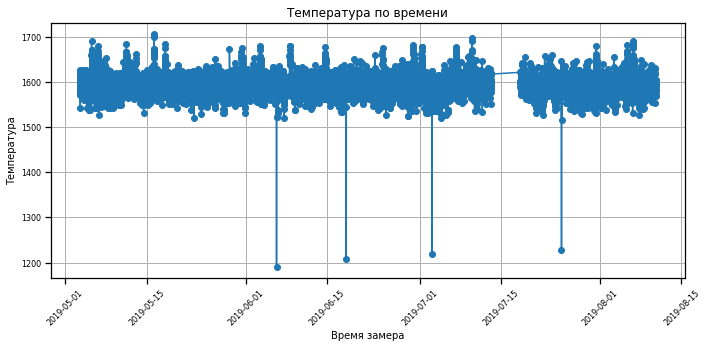

In [49]:
# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(df_temp['время_замера'], df_temp['температура'], marker='o', linestyle='-')

#plt.xlim(pd.to_datetime('2019-07-08'), pd.to_datetime('2019-07-22'))
 
# Настройка подписей и заголовка
plt.xlabel('Время замера')
plt.ylabel('Температура')
plt.title('Температура по времени')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Отмечается отсутсвие данных в период с 13 по 18 июля, что может быть обусловлено проведением технического обслуживания оборудования. Так же отмечается несколько точек с температурой ниже 1300, эти значения похожи на выбросы.

In [50]:
df_temp.query('температура < 1300')

,key,время_замера,температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0


Все низкие температуры соответствуют начальным условиям. Согласно уточнениям Заказчика это выбросы, следовательно необходимо удалить все столбцы с этими ключами.

In [51]:
# Находим ключи, где 'температура' < 1300
keys_with_low_temp = df_temp[df_temp['температура'] < 1300]['key'].unique()

# Удаляем все строки с этими ключами
df_temp = df_temp[~df_temp['key'].isin(keys_with_low_temp)]

In [52]:
# Проверка
df_temp.query('температура < 1300')

,key,время_замера,температура


Посмотрим на динамику изменения температуры по отдельным ключам.

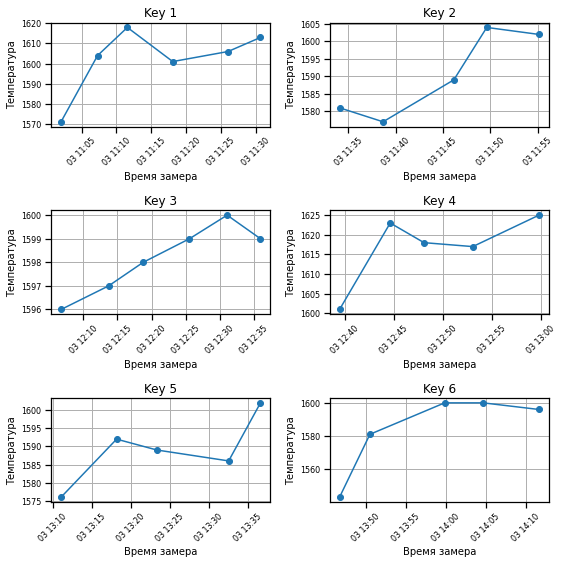

In [53]:
# Группируем по key и выбираем первые 6 ключей
unique_keys = df_temp['key'].unique()[:6]

# Строим графики для первых 10 ключей
plt.figure(figsize=(8, 8))

for i, key in enumerate(unique_keys, 1):
    plt.subplot(3, 2, i)  # 3 строк, 2 столбца для 6 графиков
    key_data = df_temp[df_temp['key'] == key]
    
    plt.plot(key_data['время_замера'], key_data['температура'], marker='o', linestyle='-', label=f'Key {key}')
    plt.title(f'Key {key}')
    plt.xlabel('Время замера')
    plt.ylabel('Температура')
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.show()

Динамика поведения температуры со временем для разных ковшей отличается.

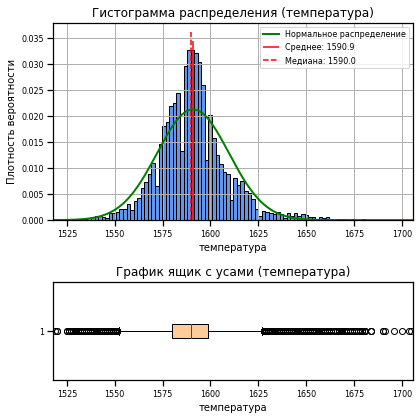

count    13905.0
mean      1590.9
std         18.8
min       1519.0
1%        1547.0
25%       1580.0
50%       1590.0
75%       1599.0
99%       1652.0
max       1705.0
Name: температура, dtype: float64

In [54]:
# Вызовем функцию построения частотной гистограммы распределения и ящика с усами для температуры
draw_quantity(df_temp['температура'], 100)

`Время_замера` можно преобразовать в количество дней/часов/минут с определенного момента (например, с времени предыдущего замера). В итоге временные признаки могут быть преобразованы в численные.

In [55]:
# Добавим время, прошедшее с предыдущего замера для каждого key
df_temp['дельта_времени_мин'] = df_temp.groupby('key')['время_замера'].diff().dt.total_seconds() / 60
df_temp['дельта_времени_мин'] = df_temp['дельта_времени_мин'].fillna(0)

In [56]:
df_temp.head()

,key,время_замера,температура,дельта_времени_мин
0,1,2019-05-03 11:02:04,1571.0,0.000000
1,1,2019-05-03 11:07:18,1604.0,5.233333
2,1,2019-05-03 11:11:34,1618.0,4.266667
3,1,2019-05-03 11:18:04,1601.0,6.500000
4,1,2019-05-03 11:25:59,1606.0,7.916667


In [57]:
# Агрегирование данныx по ключу key с вычислением начальной, конечной температуры и суммарного времени между замерами
df_temp_grouped = df_temp.groupby('key').agg(
    начальная_температура=('температура', 'first'),  # Начальная температура
    конечная_температура=('температура', 'last'),  # Конечная температура (если нужно)
    время_между_замерами_температуры=('дельта_времени_мин', 'sum'),
).reset_index()

In [58]:
df_temp = df_temp_grouped
df_temp.head()

,key,начальная_температура,конечная_температура,время_между_замерами_температуры
0,1,1571.0,1613.0,28.566667
1,2,1581.0,1602.0,21.083333
2,3,1596.0,1599.0,29.216667
3,4,1601.0,1625.0,20.333333
4,5,1576.0,1602.0,25.600000


Данные признаки будут использованы при построении модели.

### Время и мощность нагрева

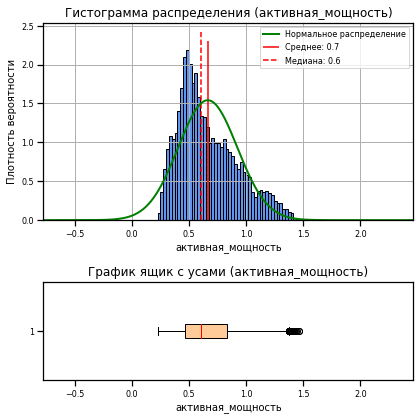

count    14876.0
mean         0.7
std          0.3
min          0.2
1%           0.3
25%          0.5
50%          0.6
75%          0.8
99%          1.3
max          1.5
Name: активная_мощность, dtype: float64

In [59]:
# Вызовем функцию построения частотной гистограммы распределения и ящика с усами для активной мощности
draw_quantity(df_arc['активная_мощность'], 50)

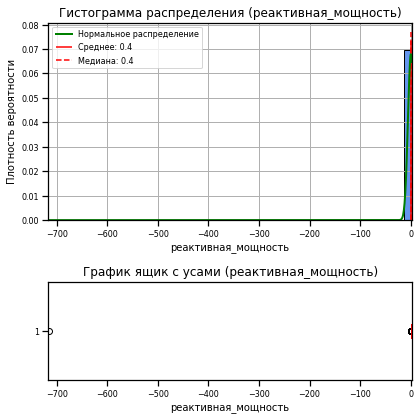

count    14876.0
mean         0.4
std          5.9
min       -715.5
1%           0.2
25%          0.3
50%          0.4
75%          0.6
99%          1.0
max          1.3
Name: реактивная_мощность, dtype: float64

In [60]:
# Вызовем функцию построения частотной гистограммы распределения и ящика с усами для реактивной мощности
draw_quantity(df_arc['реактивная_мощность'], 50)

В столбце `реактивная_мощность` присутствует подозрительное отрицательное значение для переменной, которая не может быть отрицательной.

In [61]:
df_arc.query('реактивная_мощность < 0')

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [62]:
df_arc.query('key == 2116')

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [63]:
# Найдем ключ, где есть отрицательные значения в 'реактивная_мощность'
keys_to_remove = df_arc[df_arc['реактивная_мощность'] < 0]['key'].unique()

# Удалим все строки с этим ключем
df_arc = df_arc[~df_arc['key'].isin(keys_to_remove)]

In [64]:
# Проверка
df_arc.query('реактивная_мощность < 0')

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность


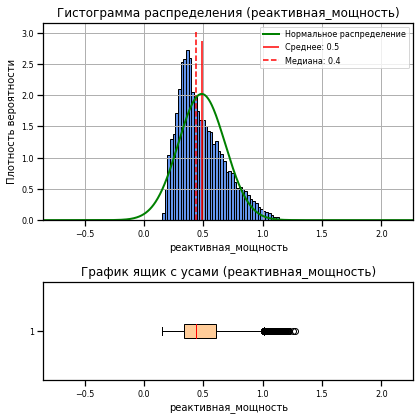

count    14872.0
mean         0.5
std          0.2
min          0.2
1%           0.2
25%          0.3
50%          0.4
75%          0.6
99%          1.0
max          1.3
Name: реактивная_мощность, dtype: float64

In [65]:
# Еще раз вызовем функцию построения частотной гистограммы распределения и ящика с усами для реактивной мощности
draw_quantity(df_arc['реактивная_мощность'], 50)

Имея время начала и окончания нагрева, мы можем вычислить продолжительность нагрева на каждой итерации.

In [66]:
# Вычисление продолжительности нагрева в минутах
df_arc_copy = df_arc.copy()
df_arc_copy['продолжительность_нагрева_дугой_мин'] = (df_arc['конец_нагрева_дугой'] - df_arc['начало_нагрева_дугой']).dt.total_seconds() / 60

Активная (P) и реактивная (Q) мощности — это основные компоненты полной мощности. Они связаны с тем, как энергия передается и используется в системе.
Полная мощность расчитывается как корень квадратный из суммы квадратов мощностей. Введем этот параметр:

In [67]:
# Рассчет полной мощности
df_arc_copy['полная_мощность'] = np.sqrt(df_arc['активная_мощность']**2 + df_arc['реактивная_мощность']**2)

`Работа` может быть рассчитана как произведение мощности на время.

In [68]:
# Добавим новый признак работа
df_arc_copy['работа'] = df_arc_copy['активная_мощность'] * df_arc_copy['продолжительность_нагрева_дугой_мин']

In [69]:
df_arc_copy.head()

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,продолжительность_нагрева_дугой_мин,полная_мощность,работа
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,3.800000,0.371123,1.159494
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,3.083333,0.902319,2.360779
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,2.866667,0.722536,1.663564
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,6.083333,0.642824,3.154184
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,2.466667,1.079934,2.138928


In [70]:
# Агрегируем данные по ключу 'key'
df_arc_grouped = df_arc_copy.groupby('key').agg(
    продолжительность_нагрева_дугой=('продолжительность_нагрева_дугой_мин', 'sum'),
    работа=('работа', 'mean'),
    полная_мощность=('полная_мощность', 'mean'),
).reset_index()

In [71]:
df_arc = df_arc_grouped
df_arc.head()

,key,продолжительность_нагрева_дугой,работа,полная_мощность
0,1,18.300000,2.095390,0.743747
1,2,13.516667,1.647007,0.647087
2,3,10.916667,1.939249,1.003845
3,4,12.350000,2.265459,0.850010
4,5,14.483333,1.717419,0.704245


Новые параметры могут быть полезны для анализа эффективности и характеристик системы нагрева.

### Объём подаваемого газа

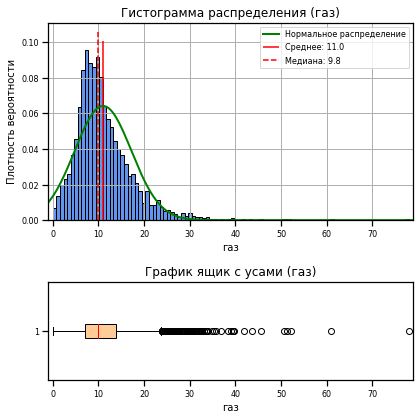

count    3239.0
mean       11.0
std         6.2
min         0.0
1%          1.1
25%         7.0
50%         9.8
75%        13.8
99%        31.6
max        78.0
Name: газ, dtype: float64

In [72]:
# Вызовем функцию построения частотной гистограммы распределения и ящика с усами для объема подачи газа
draw_quantity(df_gas['газ'], 100)

### Объёмы подачи сыпучих материалов

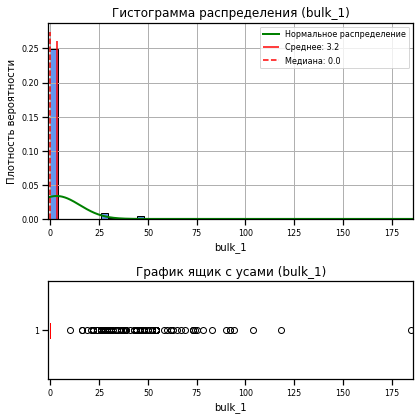

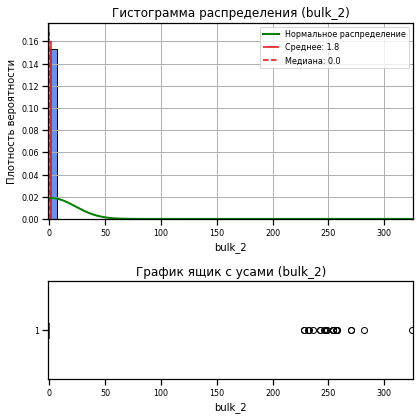

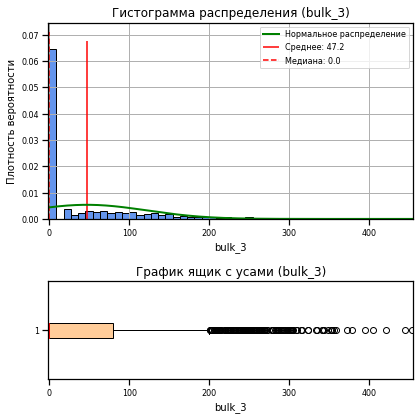

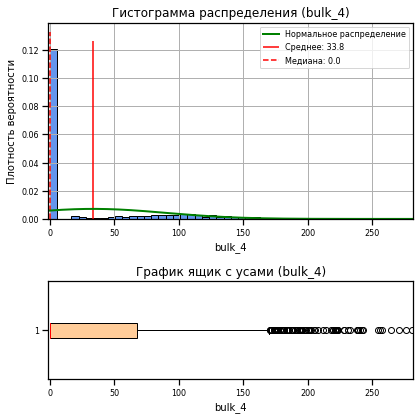

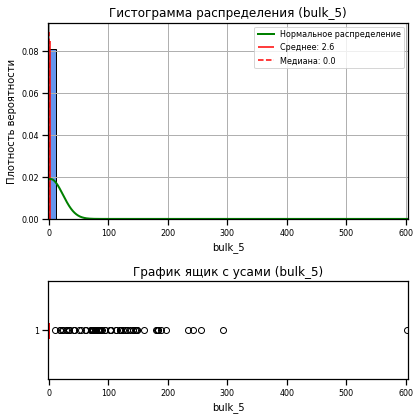

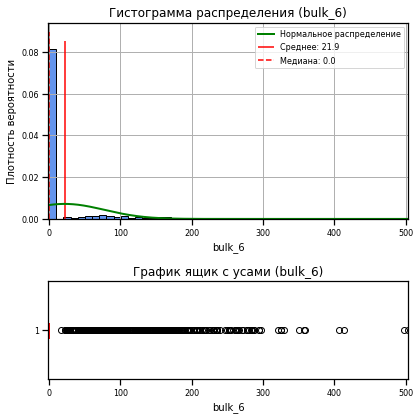

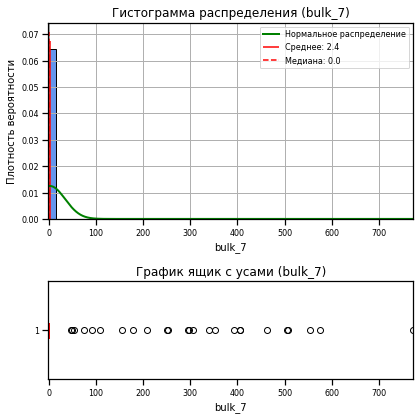

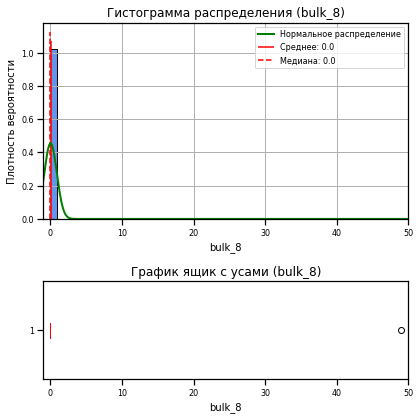

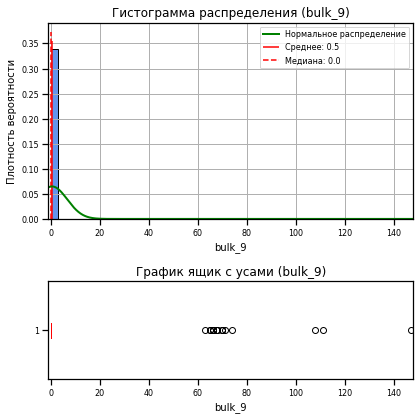

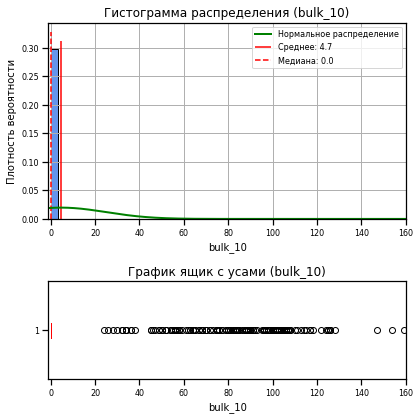

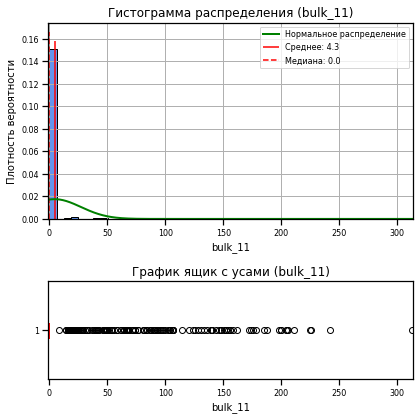

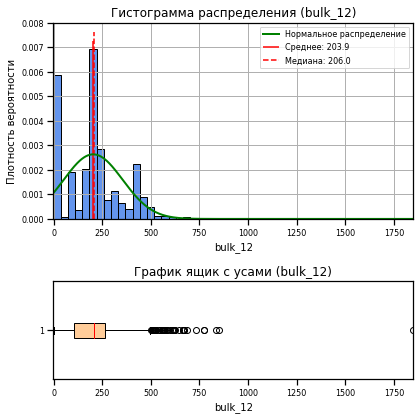

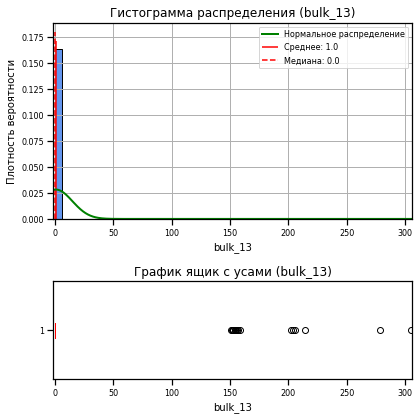

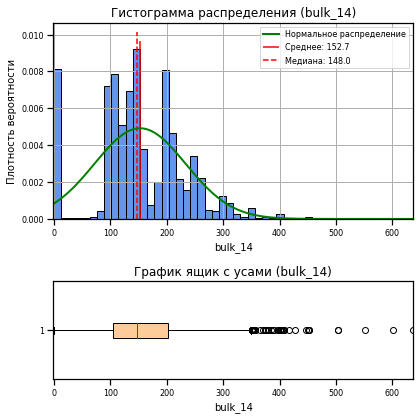

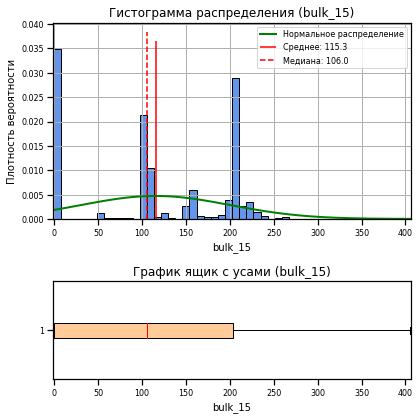

In [73]:
# Исключаем столбец 'key' и вызовем функцию построения частотной гистограммы распределения и ящика с усами для остальных признаков
for column in df_bulk.columns:
    if column != 'key':
        draw_quantity(df_bulk[column], 50)

### Объёмы подачи проволочных материалов

Строим график для столбца: wire_1


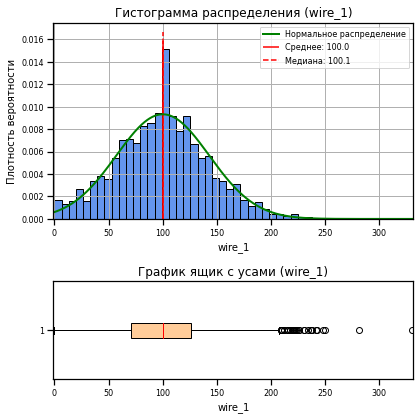

Строим график для столбца: wire_2


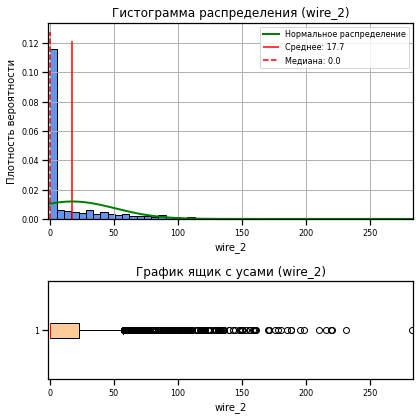

Строим график для столбца: wire_3


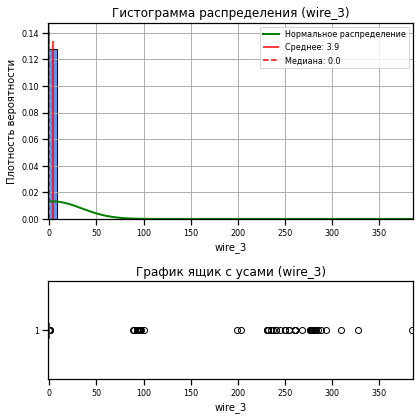

Строим график для столбца: wire_4


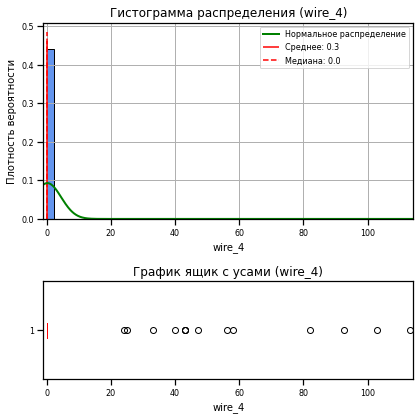

Строим график для столбца: wire_5


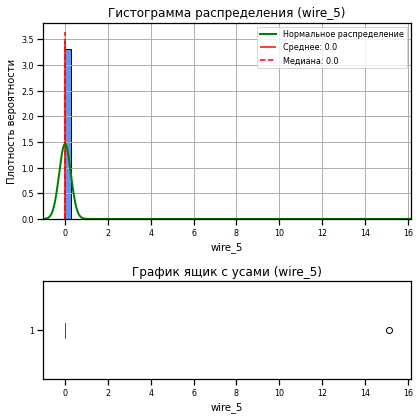

Строим график для столбца: wire_6


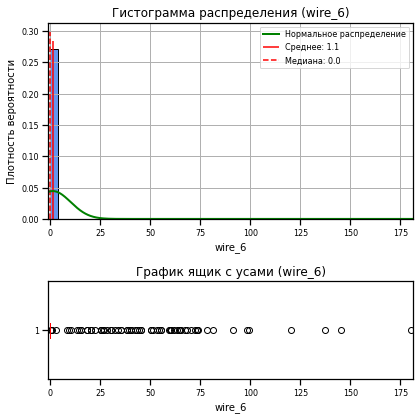

Строим график для столбца: wire_7


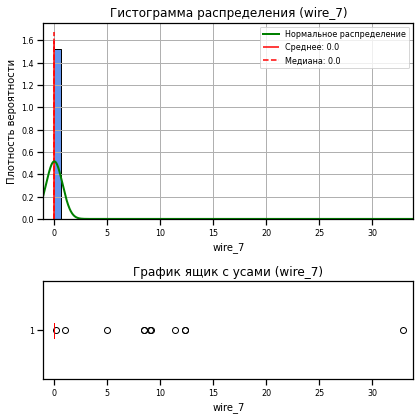

Строим график для столбца: wire_8


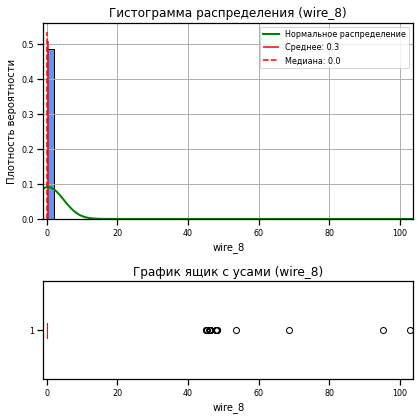

Строим график для столбца: wire_9


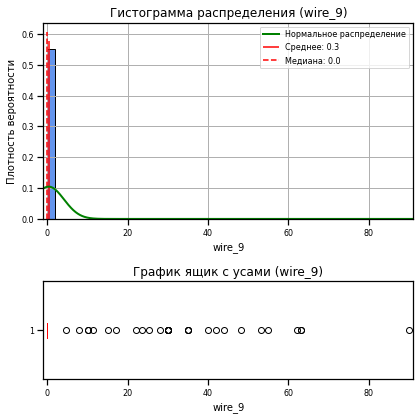

In [74]:
# Исключаем столбец 'key' и вызовем функцию построения частотной гистограммы распределения и ящика с усами для остальных признаков
for column in df_wire.columns:
    if column != 'key':
        print(f"Строим график для столбца: {column}")
        draw_quantity(df_wire[column], 50)

Распределение объемов подаваемых сыпучих и проволочных материалов по ряду признаков выглядит специфически, что обусловлено тем, что одни материалы подаются намного чаще других. После объединения таблиц удалим признаки с объемами подаваемых сыпучих и проволочных матеиалов, которые не используются в более 80% случаев.

### Вывод

- В таблице `df_temp` отмечается отсутствие данных по температуре в период с 13 по 18 июля, что может быть связано с техническим обслуживанием оборудования. Температура ниже 1300°C отнесена к выбросам и четыре ковша удалено из `df_temp`.
- В `df_arc` в столбце реактивная мощность обнаружено отрицательное значение, что является не физичным. Этот ковш удален из датафрейма.
- Временные метки преобразованы в интервалы времени: дельта_времени_мин и продолжительность_нагрева_дугой_мин. 
- Вычислены дополнительные признаки:
    - Полная мощность: корень квадратный из суммы квадратов активной и реактивной мощностей.
    - Работа: произведение мощности на время нагрева.
- Выполнено агрегирование данных в таблице `df_temp` по столбцу `key`, в результате получается новая таблица со столбцами:
    - `начальная_температура`: для каждой группы берется первое значение в столбце температура. Это отражает температуру в момент первого замера для конкретного `key`.
    - `конечная-температура`: для каждой группы берется последнее значение в столбце температура. Это позволяет определить температуру в момент последнего замера на выходе ковша для данного `key`.
    - Суммарное время между замерами (`время_между_замерами_температуры`): суммируются значения в столбце дельта_времени_мин, который содержит временные интервалы между последовательными замерами. Это даёт общее время, прошедшее между начальным и последним замером для каждой группы.
Итоговый датафрейм содержит одну строку для каждого уникального значения `key`.
- Выполнено агрегирование данных в таблице `df_arc` по столбцу `key`, в результате получается новая таблица со столбцами:
    - `продолжительность_нагрева_дугой`:cуммируются значения из столбца продолжительность_нагрева_дугой_мин, что дает общую длительность всех этапов нагрева дугой для каждого ключа key.
    - `работа`: среднее значения из столбца работа. Это позволяет определить среднюю работу, выполненную в процессе нагрева для каждой группы.
    - `полная_мощность`:среднее значения из столбца полная_мощность. Это дает среднюю мощность, использованную в процессе нагрева для каждой группы.
    
**Рекомендации:**
- Уточнить причины отсутствия данных по температуре и возможность их восстановления.
- Использовать новые предложенные признаки при построении модели.
- Не использовать датафреймы `df_bulk_time` и `df_wire_time` при построении модели, ввиду отсутствия в них дополнительной полезной информации. 
- Исключить признаки объемов подачи материалов с низкой частотой использования (удалить признаки с объемами материалов, которые используются менее чем в 20% случаев.)

## Объединение данных

In [75]:
# Цикл для вывода количества уникальных ключей в каждом DataFrame с отображением имени
for name, df in dfs:
    unique_keys_count = df['key'].nunique()
    print(f'Для датафрейма {name} количество уникальных ключей: {unique_keys_count}')

Для датафрейма df_temp количество уникальных ключей: 3216
Для датафрейма df_arc количество уникальных ключей: 3214
Для датафрейма df_gas количество уникальных ключей: 3239
Для датафрейма df_bulk количество уникальных ключей: 3129
Для датафрейма df_bulk_time количество уникальных ключей: 3129
Для датафрейма df_wire количество уникальных ключей: 3081
Для датафрейма df_wire_time количество уникальных ключей: 3081


В различных датафреймах присутствует различное количество ключей, поэтому объединение будем проводить так, чтобы в итоговый датафрейм попали те строки, для которых есть соответствующие ключи во всех датафреймах. Для этого будем использовать соединение inner.

In [76]:
# Список датафреймов
dfset = [df_temp, df_arc, df_gas, df_wire, df_bulk] # df_wire_time, df_bulk_time не используем

# Используем reduce для объединения всех датафреймов по ключу
df = reduce(lambda left, right: pd.merge(left, right, on='key', how='inner'), dfset)

In [77]:
df.shape

(2324, 32)

In [78]:
df.head()

,key,начальная_температура,конечная_температура,время_между_замерами_температуры,продолжительность_нагрева_дугой,работа,полная_мощность,газ,wire_1,wire_2,...,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,1571.0,1613.0,28.566667,18.300000,2.095390,0.743747,29.749986,60.059998,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,1581.0,1602.0,21.083333,13.516667,1.647007,0.647087,12.555561,96.052315,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,1596.0,1599.0,29.216667,10.916667,1.939249,1.003845,28.554793,91.160157,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,1601.0,1625.0,20.333333,12.350000,2.265459,0.850010,18.841219,89.063515,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,1576.0,1602.0,25.600000,14.483333,1.717419,0.704245,5.413692,89.238236,9.11456,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [79]:
df.tail()

,key,начальная_температура,конечная_температура,время_между_замерами_температуры,продолжительность_нагрева_дугой,работа,полная_мощность,газ,wire_1,wire_2,...,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
2319,2495,1570.0,1591.0,23.000000,12.050000,2.381414,0.967180,7.125735,89.150879,0.00000,...,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2320,2496,1554.0,1591.0,28.416667,15.666667,1.875618,0.845053,9.412616,114.179527,0.00000,...,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2321,2497,1571.0,1589.0,16.033333,9.483333,3.779593,1.453639,6.271699,94.086723,9.04800,...,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2322,2498,1591.0,1594.0,25.333333,12.500000,1.583063,0.781983,14.953657,118.110717,0.00000,...,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0
2323,2499,1569.0,1603.0,25.616667,14.716667,1.783011,0.542313,11.336151,110.160958,50.00528,...,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0


Как ранее было отмечено одни материалы подаются намного чаще других, поэтому удалим признаки с объемами подаваемых сыпучих и проволочных матеиалов, которые не используются в более 80% случаев.

In [80]:
# Рассчитываем процент значений, равных 0, для каждого столбца
zero_percentage = (df == 0).mean() * 100

# Отбираем столбцы, где более 80% значений равны 0
columns_to_drop = zero_percentage[zero_percentage > 80].index

# Удаляем эти столбцы из DataFrame
df = df.drop(columns=columns_to_drop, axis=1)

In [81]:
df.shape

(2324, 15)

In [82]:
df.sample(n=5)

,key,начальная_температура,конечная_температура,время_между_замерами_температуры,продолжительность_нагрева_дугой,работа,полная_мощность,газ,wire_1,wire_2,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
1440,1547,1602.0,1587.0,36.033333,3.683333,0.906497,0.534608,10.906515,143.114396,0.00000,0.0,90.0,0.0,0.0,0.0
1390,1490,1606.0,1596.0,30.916667,11.350000,2.941190,1.022114,17.677616,158.137192,0.00000,99.0,77.0,411.0,206.0,210.0
893,973,1556.0,1579.0,21.600000,9.916667,1.581556,0.778331,7.446602,45.115197,0.00000,207.0,0.0,0.0,132.0,0.0
244,275,1548.0,1598.0,30.916667,18.833333,2.103052,0.892793,13.648286,100.114563,14.06496,53.0,0.0,460.0,255.0,204.0
2280,2451,1557.0,1597.0,44.950000,27.100000,2.774274,0.719906,11.059257,13.016640,0.00000,0.0,0.0,361.0,235.0,204.0


<a id="5-bullet"></a>

##  Исследовательский анализ данных объединённого датафрейма

In [83]:
# Удалим ключ, чтобы не было утечки данных
df = df.drop('key', axis=1)

In [84]:
# Поиска явных дубликатов
df.duplicated().sum()

0

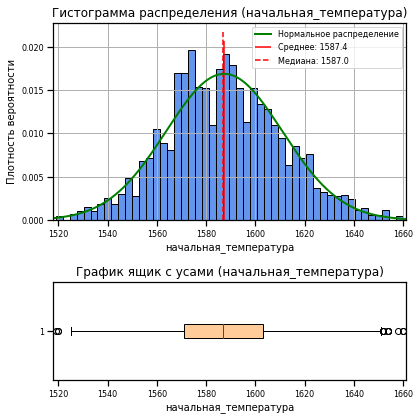

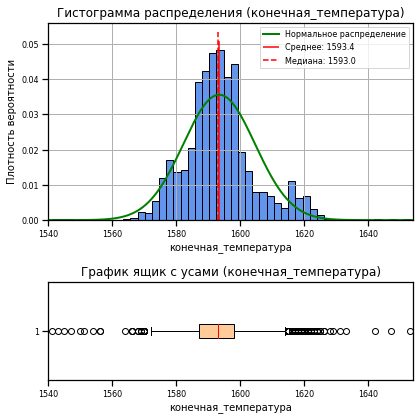

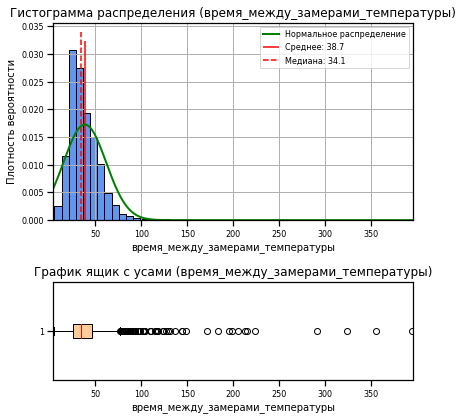

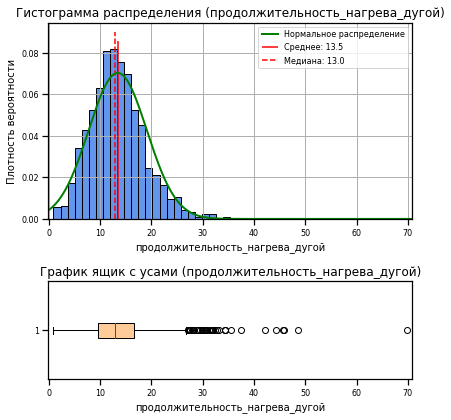

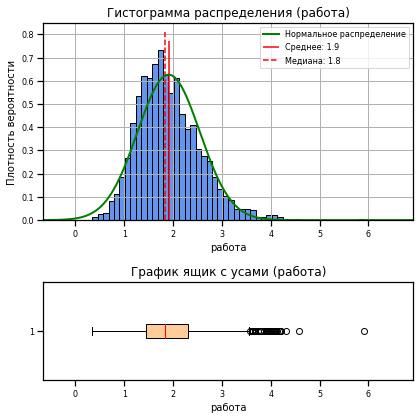

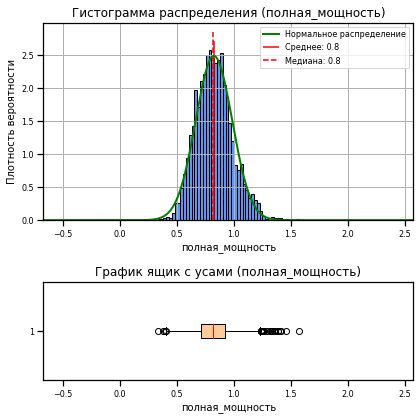

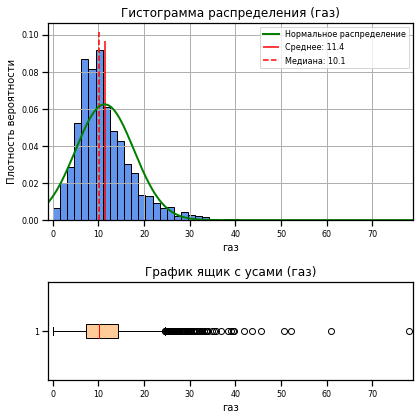

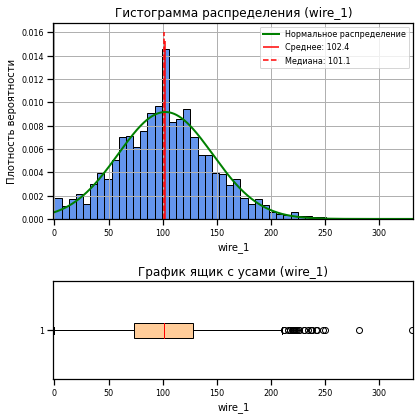

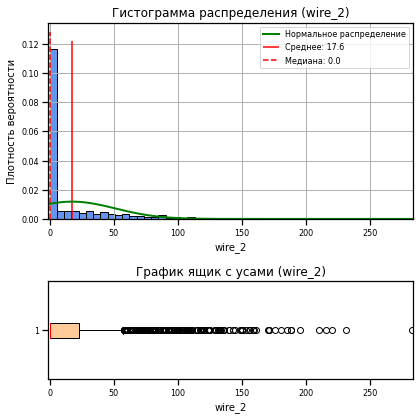

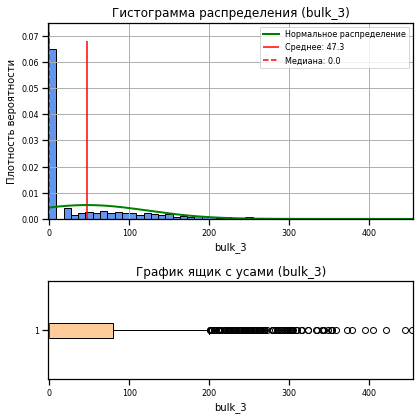

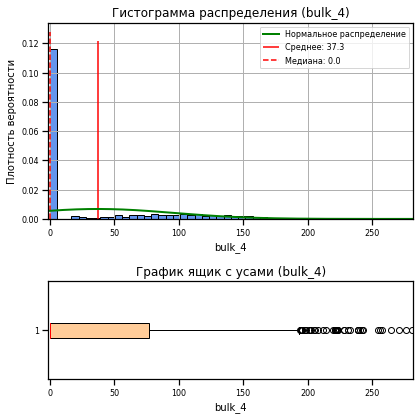

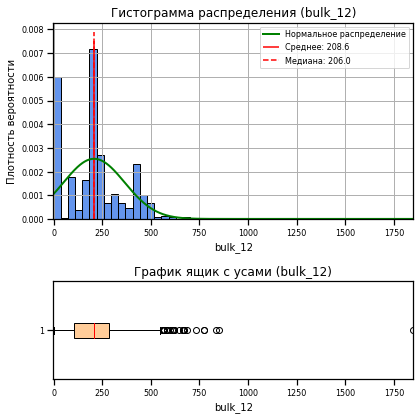

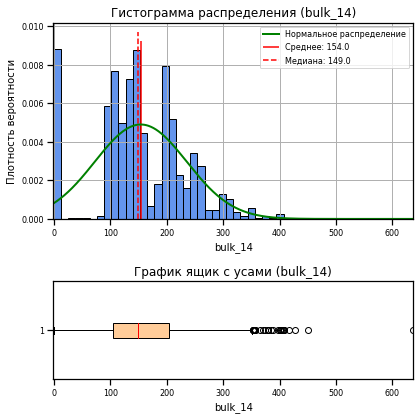

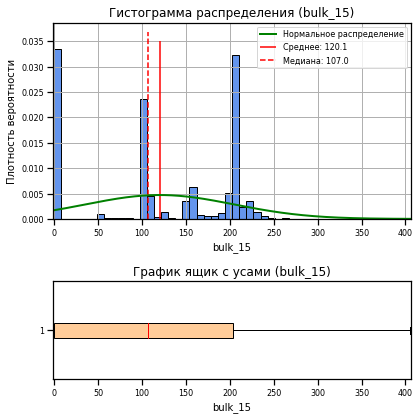

In [85]:
# Вызовем функцию построения частотной гистограммы распределения и ящика с усами для всех столбцов датафрейма
for column in df.columns:
    draw_quantity(df[column], 50)

## Корреляционный анализ

Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками.

In [86]:
# Cоздаём список с наименованиями непрерывных признаков
interval_cols = df.columns.tolist()
#interval_cols

In [87]:
# Рассчитываем матрицу phi_K корреляций
phik_overview = df.phik_matrix(interval_cols=interval_cols)

In [88]:
# Создадим функцию для отрисовки матрицы корреляций
def plot_correlation_matrix(matrix, x_labels, y_labels, vmin=0, vmax=1, color_map='coolwarm', title='', fontsize_factor=1, figsize=(10, 10)):
    plt.figure(figsize=figsize)  # Увеличенный размер
    # Вызов heatmap с параметрами для линий между ячейками
    sns.heatmap(
        matrix,
        annot=True,  # Показывать значения в ячейках
        cmap=color_map,
        vmin=vmin,
        vmax=vmax,
        xticklabels=x_labels,
        yticklabels=y_labels,
        linecolor='white',
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}  # Настройка цветовой шкалы
    )
    plt.xticks(fontsize=fontsize_factor * 14, rotation=45, ha='right')  # Поворот меток оси X
    plt.yticks(fontsize=fontsize_factor * 14)
    plt.title(title, fontsize=20 * fontsize_factor)
    plt.tight_layout()  # Уменьшает пробелы
    plt.show()

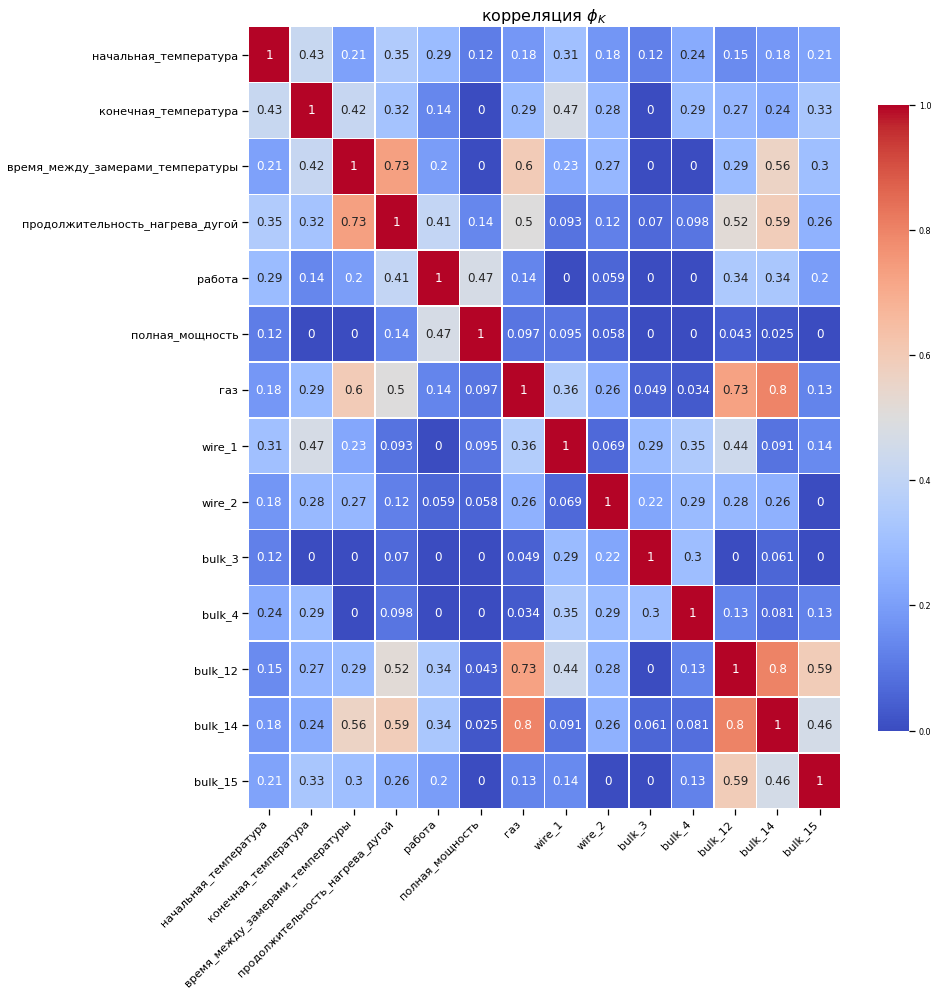

In [89]:
# Вызовем функцию для отрисовки матрицы корреляций
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map='coolwarm',
    title=r'корреляция $\phi_K$',
    fontsize_factor=0.8,  # Уменьшенный шрифт
    figsize=(14, 14)  # Увеличенный размер графика
)

Из предоставленной матрицы корреляций видно, что на конечную температуру в большей степени влияют `начальная_температура` и `время_между_замерами_температуры`.

In [90]:
# Построим VIF таблицу
# Добавляем константу для расчета VIF
X = add_constant(df)
vif_data = pd.DataFrame()

# Рассчитываем VIF для каждого признака
vif_data["Признак"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
for i in range(X.shape[1])]

# Выводим таблицу с VIF
vif_data

,Признак,VIF
0,const,26328.403914
1,начальная_температура,2.907395
2,конечная_температура,1.961958
3,время_между_замерами_температуры,2.923684
4,продолжительность_нагрева_дугой,5.178798
5,работа,2.583701
6,полная_мощность,1.847287
7,газ,1.377470
8,wire_1,1.320337
9,wire_2,1.144412


## Построение моделей

### Обучение моделей

In [91]:
# Создадим функцию оптимизации числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [92]:
# Оптимизируем числовые типы данных
df = optimize_memory_usage(df, print_size=True)

Размер использования памяти: до  0.27 Mb - после  0.14 Mb (46.7%)


In [93]:
# Cохраним входные признаки в переменную X
X = df.drop('конечная_температура', axis=1)

# Cохраним целевой признак в переменную y
y = df['конечная_температура'] 

In [94]:
# Разделим входные и целевой признаки на тренировочную и тестовую выборки в соотношении 3:1. 
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=0.25
    )

In [95]:
# Посмотрим на размер тренировочной выборки
X_train.shape

(1743, 13)

In [96]:
# Посмотрим на размер тестовой выборки
X_test.shape

(581, 13)

In [97]:
# Создадим метрику MAE
def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# Пользовательская метрика для использования в кросс-валидации
MAE_scorer = make_scorer(mae, greater_is_better=False)

In [98]:
# Пайплайн для Decision Tree
dt_pipe = Pipeline([
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# Пайплайн для Random Forest
rf_pipe = Pipeline([
    ('models', RandomForestRegressor(random_state=RANDOM_STATE))
]) 

# Пайплайн для модели LightGBM
lgb_pipe = Pipeline([
    ('models', LGBMRegressor(random_state=RANDOM_STATE))
])

# Пайплайн для CatBoost Regressor
cb_pipe = Pipeline([
    ('models', CatBoostRegressor(random_state=RANDOM_STATE, verbose=0))
])

# Гиперпараметры для DecisionTreeRegressor
param_distributions_dt = {
    'models__max_depth': [2, 10, 20],
    'models__min_samples_split': [2, 5, 10],
    'models__min_samples_leaf': [1, 2, 5]
}

# Гиперпараметры для RandomForestRegressor
param_distributions_rf = {
    'models__max_depth': [2, 10, 20],
    'models__min_samples_split': [2, 5, 10],
    'models__n_estimators': [50, 100, 200],
}

# Гиперпараметры для LightGBM
param_distributions_lgb = {
    'models__num_leaves': [20, 30, 50],
    'models__learning_rate': [0.05, 0.1, 0.5],
    'models__n_estimators': [50, 100, 500]
}

# Гиперпараметры для CatBoostRegressor
param_distributions_cb = {
    'models__depth': [6, 8, 10],
    'models__learning_rate': [0.05, 0.1, 0.5],
    'models__iterations': [50, 100, 500],
    'models__l2_leaf_reg': [3, 10, 20],
    #'models__subsample': [0.7, 0.8, 1.0],
    #'models__colsample_bylevel': [0.7, 0.8, 1.0]
}

# Настройка RandomizedSearchCV для каждой модели
def randomized_search_model(pipe, param_distributions, X_train, y_train):
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_distributions,
        n_iter=10,
        scoring=MAE_scorer,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        cv=3,
        return_train_score=True,
        refit=True 
    )
    
    search.fit(X_train, y_train)
    return search

# Запуск поиска для каждой модели
dt_search = randomized_search_model(dt_pipe, param_distributions_dt, X_train, y_train)
rf_search = randomized_search_model(rf_pipe, param_distributions_rf, X_train, y_train)
lgb_search = randomized_search_model(lgb_pipe, param_distributions_lgb, X_train, y_train)
cb_search = randomized_search_model(cb_pipe, param_distributions_cb, X_train, y_train)

In [99]:
def get_results(search, model_name):
    # Получаем данные о лучшей модели
    best_index = search.best_index_
    mean_fit_time = search.cv_results_['mean_fit_time'][best_index]
    mean_score_time = search.cv_results_['mean_score_time'][best_index]
    
    # Предсказания на тренировочной выборке для MAE
    y_train_pred = search.predict(X_train)
    mae_train = mae(y_train, y_train_pred)
    
    results_df = pd.DataFrame(search.cv_results_)
    results_summary = results_df[['params', 'mean_test_score']].copy()
    results_summary.columns = ['Параметры', 'Средний MAE (CV)']
    results_summary['Средний MAE (CV)'] = -results_summary['Средний MAE (CV)']
    results_summary['Модель'] = model_name  # Добавление названия модели
    results_summary['Время обучения (с)'] = mean_fit_time
    results_summary['Время предсказания (с)'] = mean_score_time
    
    return results_summary.sort_values(by='Средний MAE (CV)').round(2)

# Получаем результаты для каждой модели
dt_results = get_results(dt_search, 'DecisionTreeRegressor')
rf_results = get_results(rf_search, 'RandomForestRegressor')
lgb_results = get_results(lgb_search, 'LGBMRegressor')
cb_results = get_results(cb_search, 'CatBoostRegressor')

# Находим лучшую модель для каждой из моделей
best_dt = dt_results.nsmallest(1, 'Средний MAE (CV)')
best_rf = rf_results.nsmallest(1, 'Средний MAE (CV)')
best_lgb = lgb_results.nsmallest(1, 'Средний MAE (CV)')
best_cb = cb_results.nsmallest(1, 'Средний MAE (CV)')

# Объединяем результаты в одну таблицу
combined_best_results = pd.concat([best_dt, best_rf, best_lgb, best_cb], ignore_index=True)

# Выводим объединенные результаты
print("Объединенные результаты лучших моделей:")
combined_best_results[['Модель', 'Параметры', 'Средний MAE (CV)', 'Время обучения (с)', 'Время предсказания (с)']]

Объединенные результаты лучших моделей:


,Модель,Параметры,Средний MAE (CV),Время обучения (с),Время предсказания (с)
0,DecisionTreeRegressor,"{'models__min_samples_split': 5, 'models__min_...",7.88,0.01,0.00
1,RandomForestRegressor,"{'models__n_estimators': 100, 'models__min_sam...",6.36,1.05,0.02
2,LGBMRegressor,"{'models__num_leaves': 50, 'models__n_estimato...",6.39,1.50,0.03
3,CatBoostRegressor,"{'models__learning_rate': 0.05, 'models__l2_le...",6.14,2.00,0.00


### Выбор лучшей модели

In [100]:
# Находим строку с наименьшим значением 'Средний MAE (CV)' в объединённой таблице
best_row = combined_best_results.nsmallest(1, 'Средний MAE (CV)').iloc[0]

# Определяем, какая модель оказалась лучшей
best_model_name = best_row['Модель']

# Сопоставляем название модели с объектом поиска
model_search_map = {
    'DecisionTreeRegressor': dt_search,
    'RandomForestRegressor': rf_search,
    'LGBMRegressor': lgb_search,
    'CatBoostRegressor': cb_search
}

# Извлекаем объект поиска для лучшей модели
best_search = model_search_map[best_model_name]

# Сохраняем лучшую модель
best_model = best_search.best_estimator_

# Выводим информацию о лучшей модели
print(f"Лучшая модель: {best_model_name}")
print("Параметры лучшей модели:")
best_model.get_params()

Лучшая модель: CatBoostRegressor
Параметры лучшей модели:


{'memory': None,
 'steps': [('models', <catboost.core.CatBoostRegressor at 0x7f6f36bd6b80>)],
 'transform_input': None,
 'verbose': False,
 'models': <catboost.core.CatBoostRegressor at 0x7f6f36bd6b80>,
 'models__loss_function': 'RMSE',
 'models__verbose': 0,
 'models__random_state': 91224,
 'models__learning_rate': 0.05,
 'models__l2_leaf_reg': 3,
 'models__iterations': 500,
 'models__depth': 6}

Для дальнейшего использования рекомендуется выбирать CatBoostRegressor, если время обучения не является критичным.

### Анализ лучшей модели

In [101]:
# Предсказание лучшей модели на тестовой выборке
y_test_pred = best_model.predict(X_test)

# Вычислим MAE и R² на тестовой выборке
mae_test = mae(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Выводим результатов
print(f"Метрика MAE для лучшей модели на тестовой выборке: {mae_test:.2f}")
print(f"Метрика R² для лучшей модели на тестовой выборке: {r2_test:.1f}")

Метрика MAE для лучшей модели на тестовой выборке: 5.84
Метрика R² для лучшей модели на тестовой выборке: 0.5


MAE - это средняя абсолютная ошибка модели на тестовой выборке. В данном случае предсказания модели отклоняются от истинных значений в среднем на 5.84 единиц. Данное значение удовлетворяет требованиям задачи.

R² показывает, какая доля дисперсии целевой переменной объясняется моделью. Значение 0.5 означает, что модель объясняет 50% дисперсии в данных, что является средним результатом. Значение 1.0 означало бы идеальные предсказания, а значение 0 — полное отсутствие полезной информации.

Сравним нашу модель с константной моделью.

In [102]:
# Cоздадим и обучим DummyRegressor
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)

# Предсказание на тестовой выборке с помощью DummyRegressor
y_test_pred_dummy = dummy_regressor.predict(X_test)

# Вычислим метрику MAE для константной модели
mae_dummy = mae(y_test, y_test_pred_dummy)
print(f'Метрика MAE для константной модели: {mae_dummy:.2f}')

# Сравним с лучшей моделью
print(f'Метрика MAE для лучшей модели: {mae_test:.2f}')

if mae_test < mae_dummy:
    print('Лучшая модель превосходит константную модель.')
else:
    print('Константная модель работает не хуже лучшей модели.')

Метрика MAE для константной модели: 7.85
Метрика MAE для лучшей модели: 5.84
Лучшая модель превосходит константную модель.


 98%|===================| 568/581 [00:12<00:00]        

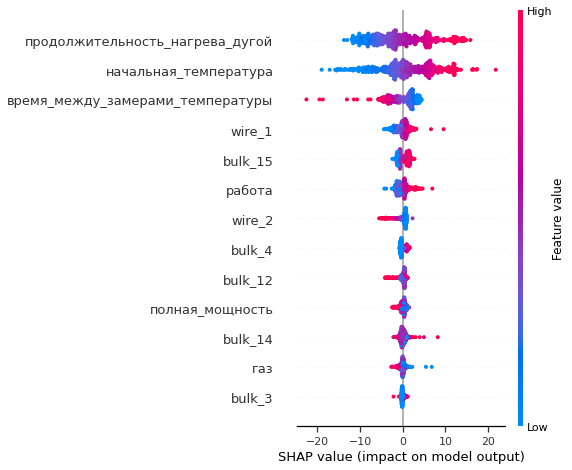

In [103]:
# Выведим график значимости признаков 
# Инициализируем объяснитель SHAP
explainer = shap.Explainer(best_search.best_estimator_.named_steps['models'], X_test)

# Вычисленим SHAP значения
shap_values = explainer(X_test)

# Отобразим сводный график важности признаков
shap.summary_plot(shap_values, X_test)

Основное влияние на предсказания модели оказывают `продолжительность_нагрева`, `начальная_температура` и `время_между_замерами`. Они играют ключевую роль в формировании итогового результата.

- Продолжительность нагрева дугой - это самый значимый параметр. Высокие значения (красные точки) увеличивают значение предсказания модели (конечной температуры), а низкие (синие точки) уменьшают их.
- Начальная температура - это второй по важности параметр. Аналогично, высокие значения приводят к увеличению предсказаний, а низкие уменьшают.
- Время между замерами температуры также существенно влияет на результат.
- Признаки, расположенные ниже имеют меньший вклад в предсказания модели.

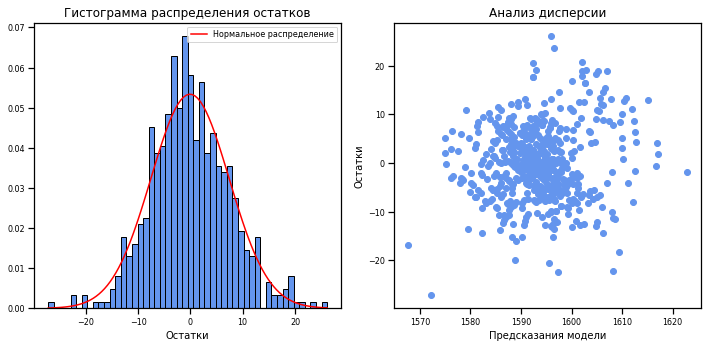

In [104]:
# Рассчитаем остатки
residuals = y_test - y_test_pred

# Проанализируем остатки с помощью графиков

# Построим гистограмму частотности распределения
# Статистика для нормального распределения
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
# Создаем оси для теоретической кривой
x = np.linspace(min(residuals), max(residuals), 100)
y = norm.pdf(x, mean_residual, std_residual)
# Построение графика
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
# Гистограмма распределения остатков
axes[0].hist(residuals, bins=50, color='cornflowerblue', edgecolor='black', density=True)
axes[0].plot(x, y, color='red', label='Нормальное распределение')  # Добавляем кривую нормального распределения
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].legend()

# Построим диаграмму рассеяния
axes[1].scatter(x=y_test_pred, y=residuals, color='cornflowerblue')
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
# Построим линию регрессии на диаграмме рассеяния
#m, b = np.polyfit(y_test_pred, residuals, 1)  # вычисленим коэффициенты
#axes[1].plot(y_test_pred, m * y_test_pred + b, color='red')  # добавим линию регрессии

plt.tight_layout()
plt.show()

In [105]:
# Абсолютные значения SHAP-значений
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Создание DataFrame для анализа
shap_analysis = pd.DataFrame({
    'Признак': X_test.columns,
    'Mean_SHAP': mean_shap_values,
    'Корреляция_с_остатками': [np.corrcoef(X_test[col], residuals)[0, 1] for col in X_test.columns]
})

# Сортировка по значимости SHAP
shap_analysis = shap_analysis.sort_values(by='Mean_SHAP', ascending=False)
display(shap_analysis)

,Признак,Mean_SHAP,Корреляция_с_остатками
2,продолжительность_нагрева_дугой,5.582608,0.035739
0,начальная_температура,5.014590,0.056749
1,время_между_замерами_температуры,2.560466,-0.051577
6,wire_1,1.072942,0.070068
12,bulk_15,1.064141,0.013625
3,работа,0.995041,0.006137
7,wire_2,0.854764,-0.018971
9,bulk_4,0.540981,0.015569
10,bulk_12,0.505607,-0.025182
4,полная_мощность,0.469015,-0.031903


Корреляция с остатками в целом слабая, что может указывать на то, что большинство признаков не вызывают значительных ошибок в прогнозах модели.

In [106]:
# Определение кастомной метрики MAE
def custom_mae(estimator, X, y):
    y_pred = estimator.predict(X)  # Предсказания модели
    return - mean_absolute_error(y, y_pred)  # Вычисляем MAE

# Вычисление важности признаков по методу случайных перестановок
result = permutation_importance(
    best_model, 
    X_test,  # тестовые данные
    y_test,  # истинные значения
    scoring=custom_mae,  # кастомная метрика MAE
    n_repeats=20,  # количество повторений для перемешивания
    random_state=RANDOM_STATE  # фиксированный random_state для воспроизводимости
)

# Получаем значения важности признаков и их стандартные отклонения
importances = result.importances_mean  # Среднее значение важности
stds = result.importances_std  # Стандартное отклонение

# Создаем DataFrame для удобства отображения
features = X_test.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Permutation Importance': importances,
    'Standard Deviation': stds
})

# Сортируем по важности
importance_df = importance_df.sort_values(by='Permutation Importance', ascending=False)

# Выводим результаты
importance_df

,Feature,Permutation Importance,Standard Deviation
0,начальная_температура,3.659626,0.210899
2,продолжительность_нагрева_дугой,3.626195,0.259926
1,время_между_замерами_температуры,1.207100,0.111777
6,wire_1,0.304375,0.069199
11,bulk_14,0.172266,0.041856
7,wire_2,0.160714,0.053077
3,работа,0.137970,0.067986
12,bulk_15,0.125832,0.033653
10,bulk_12,0.113161,0.053723
9,bulk_4,0.082152,0.034283


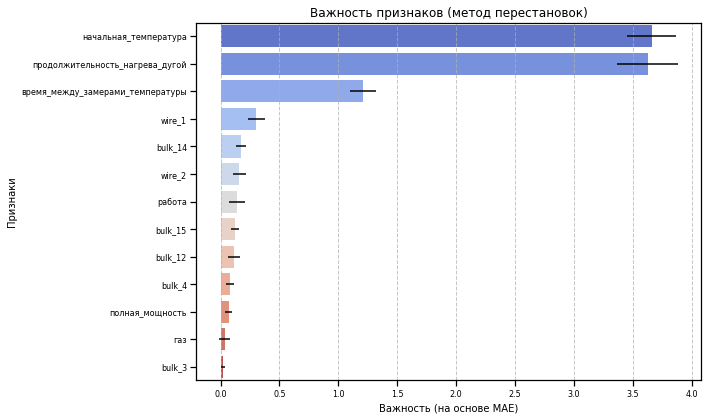

In [107]:
# Визуализируем важность признаков методом перестановок
plt.figure(figsize=(10, 6))

sns.barplot(
    x='Permutation Importance',
    y='Feature',
    xerr=importance_df['Standard Deviation'],
    data=importance_df,
    palette='coolwarm'
)

# Добавляем заголовок и подписи на русском
plt.title('Важность признаков (метод перестановок)')
plt.xlabel('Важность (на основе MAE)')
plt.ylabel('Признаки')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Судя по значению Permutation Importance признаки `bulk_3`, `bulk_4`, `газ` и `полная_мощность` не вносит значительной полезной информации в модель, Permutation Importance составляет менее 0.1.

In [108]:
# Выделим менее значемые признаки для удаления
low_importance_features = ['bulk_3', 'газ', 'полная_мощность', 'bulk_4']

# Удалим признаки из обучающего и тестового наборов
X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = X_test.drop(columns=low_importance_features)

In [109]:
# Обучим модель на оставшихся признаках
best_model.fit(X_train_reduced, y_train)

# Предсказания
y_pred_train = best_model.predict(X_train_reduced)
y_pred_test = best_model.predict(X_test_reduced)

# Метрики
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

# Вывод результатов
print(f"Метрика MAE на обучающей выборке: {train_mae:.2f}")
print(f"Мертика MAE на тестовой выборке: {test_mae:.2f}")
print(f"Метрика R² на тестовой выборке: {r2:.2f}")

Метрика MAE на обучающей выборке: 3.67
Мертика MAE на тестовой выборке: 5.80
Метрика R² на тестовой выборке: 0.55


Удаление менее значимых признаков привело к улучшению модели на тренировочной выборке (снижение MAE с 6.14 до 3.67), что может свидетельствовать о более эффективном обучении модели на важные признаки. Однако, на тестовой выборке MAE улучшился незначительно (с 5.84 до 5.8), а R² увеличился с 0.5 до 0.55, что указывает на небольшое улучшение качества предсказаний модели. 

В дальнейшем можно попробовать провести работу по добавлению новых признаков, чтобы оценить, насколько сильно это влияет на модель. На текущий момент достигнута требуемая точность по метрике MAE.

In [110]:
# Определим время конца выполнения кода
end_time = time.time()
print(f"Общее время выполения кода: {round((end_time - start_time) / 60, 1)} минут")

Общее время выполения кода: 4.2 минут


<a id="8-bullet"></a>

## Общий вывод

В процессе предобработки данных были выполнены следующие действия:
- Удалены строки с пропусками в столбце температуры, поскольку конечная температура является целевым признаком, и отсутствие данных в этом столбце делает строку непригодной для анализа.
- Заменены пропуски на нули в таблицах с данными о сыпучих и проволочных материалах, поскольку пропуски в этих столбцах означают неиспользование соответствующих материалов в процессе.
- Исключены из дальнейшего анализа таблицы времени подачи сыпучих и проволочных материалов, так как они содержат дублирующую информацию по времени, уже представленную в таблицах по объемам подачи этих материалов, что делает их дальнейшее использование избыточным.

В процессе исследовательского анализа данных были выполнены следующие действия:
- Удален выброс в столбце реактивная_мощность, где присутствовало подозрительное отрицательное значение для переменной, которая не может быть отрицательной. 
- Удалены ковши с температурой ниже 1300°C, которые были отнесены к выбросам, чтобы обеспечить точность модели.
- Временные метки преобразованы в интервалы времени, такие как дельта_времени_мин и продолжительность_нагрева_дугой_мин.
- Были вычислены дополнительные признаки:
    - Полная мощность: корень квадратный из суммы квадратов активной и реактивной мощностей.
    - Работа: произведение мощности на время нагрева.
- В таблице результатов измерения температуры выполнено агрегирование данных по столбцу key, в результате чего была создана новая таблица с такими столбцами:
    - начальная_температура: первое значение температуры для каждой группы, отражающее температуру в момент первого замера для конкретного key.
    - конечная_температура: последнее значение температуры для каждой группы, определяющее температуру на выходе ковша для данного key.
    - время_между_замерами_температуры: суммарное время между начальным и последним замером температуры для каждой группы.
- В таблице данных об электродах также выполнено агрегирование данных по столбцу key, в результате чего была создана новая таблица с такими столбцами:
    - продолжительность_нагрева_дугой: суммарное время всех этапов нагрева дугой для каждого ключа.
    - работа: среднее значение работы, выполненной в процессе нагрева.
    - полная_мощность: среднее значение полной мощности, использованной в процессе нагрева для каждой группы.

Выполнено объединение таблиц по столбцу key в единый датафрейм, включающий только значимые признаки.
- Таблицы времени подачи сыпучих и проволочных материалов в объедененом датафрейме не использовались, так как они содержат дублирующую информацию, уже представленной в таблицах по объемам подачи этих материалов, что делает их дальнейшее использование избыточным. 
- Признаки с объемами подачи сыпучих и проволочных материалов, которые не использовались в более чем 80% случаев, были удалены как избыточные.

Проведен анализ распределений признаков для объедененного датафрейма с использованием визуализаций и матрицы корреляций.

В рамках данного проекта была разработана автоматизированная система для построения, настройки и сравнения регрессионных моделей на основе современных подходов к машинному обучению. Для эффективного управления процессом обучения моделей использовались пайплайны, которые обеспечивают модульность, воспроизводимость и удобство работы.

Были созданы пайплайны для следующих регрессионных моделей:
- Decision Tree Regressor — простая, но мощная модель, способная улавливать нелинейные зависимости.
- Random Forest Regressor — ансамблевый метод, повышающий устойчивость модели за счёт объединения нескольких деревьев.
- LightGBM Regressor — разработка компании Microsoft, быстро и точно обучает градиентный бустинг. Работает с категориальными признаками напрямую.
- CatBoost Regressor — разработка Яндекса, превосходит другие алгоритмы по метрикам качества. Применяет различные техники кодирования категориальных признаков.

Для каждой модели были определены гиперпараметры для перебора. Поиск оптимальных гиперпараметров был реализован метод случайного поиска с использованием RandomizedSearchCV, кросс-валидации и метрики MAE. В результате найдены комбинации гиперпараметров, обеспечивающие наименьшую ошибку для каждой модели.

После подбора гиперпараметров все модели оценивались с использованием метрики MAE, что позволило определить модель, наилучшим образом подходящую для решения задачи.

Наилучшим образом себя проявила модель CatBoostRegressor со следующими гиперпраметрами: 

In [111]:
best_model.get_params()

{'memory': None,
 'steps': [('models', <catboost.core.CatBoostRegressor at 0x7f6f36bd6b80>)],
 'transform_input': None,
 'verbose': False,
 'models': <catboost.core.CatBoostRegressor at 0x7f6f36bd6b80>,
 'models__loss_function': 'RMSE',
 'models__verbose': 0,
 'models__random_state': 91224,
 'models__learning_rate': 0.05,
 'models__l2_leaf_reg': 3,
 'models__iterations': 500,
 'models__depth': 6}

Анализ значимости признаков модели показал, что основное влияние на предсказания модели оказывают три ключевых признака: `начальная_температура`, `продолжительность_нагрева_дугой` и `время_между_замерами_температуры`. Эти параметры играют решающую роль в формировании итогового предсказания модели, а их изменения непосредственно влияют на результат.

- `начальная_температура` и `продолжительность_нагрева_дугой` является самыми значимыми признаками и схожим образом влияют на предсказания. Высокие значения этих признаков приводят к увеличению предсказанного значения конечной температуры, в то время как низкие значения снижают предсказание.
- `время_между_замерами_температуры` также имеет значительный вклад в предсказания модели. Этот признак оказывает влияние на результат, хотя и в меньшей степени по сравнению с первыми двумя.

Проведено сопоставление построенной модели с константной моделью. 
- Константная модель, которая предсказывает фиксированное значение (среднее), показала результат MAE равный 7.85 на тестовой выборке. 
- В то время как лучшая модель (CatBoostRegressor) продемонстрировала более низкую ошибку MAE, составившую 5.84. Результаты показывают, что построенная модель значительно превосходит константную модель по точности предсказаний.

В рамках проведенного перестановочного анализа значимости признаков было установлено, что признаки `bulk_3`, `bulk_4`, `газ` и `полная_мощность` не вносят значимой информации в модель. Это позволяет сделать вывод о том, что их влияние на предсказания модели незначительно.

Удаление этих менее значимых признаков привело к улучшению модели на тренировочной выборке
- снижение MAE с 6.14 до 3.67, что может свидетельствовать о более эффективном обучении модели с фокусом на более важные признаки. 
- на тестовой выборке 
    - MAE улучшился незначительно с 5.84 до 5.8,
    - R² увеличился с 0.5 до 0.55, что указывает на небольшое улучшение качества предсказаний модели.

Признаки, используемые в итоговой модели `начальная_температура`, `время_между_замерами_температуры`, `продолжительность_нагрева_дугой`, `работа`, `wire_1`, `wire_2`, `bulk_12`, `bulk_14`, `bulk_15`.

В ходе выполнения проекта были достигнуты ключевые результаты, которые могут улучшить контроль за технологическим процессом на металлургическом комбинате и снизить энергозатраты, связанные с обработкой стали.